# Setting

In [ ]:
import torch
import torch.nn as nn

import torchvision.transforms as transforms
from torchvision.utils import save_image

from PIL import Image
from IPython.display import Image as display_image

# Function

In [ ]:
# compute channel-wise mean and variance (std)
def calc_mean_std(feat, eps = 1e-5):
  # feat: input tensor, [N, C, H, W]
  # eps: prevent division by zero
  size = feat.size()
  assert (len(size) == 4)       # ensure that the input tensor is 4-dimensional
  N, C = size[:2]
  # N: batch size
  # C: channel size
  # H, W: height, weight
  feat_var = feat.view(N, C, -1).var(dim = 2) + eps
  # feat.view(N, C, -1): reshape the tensor to [N, C, H * W], flattens the spatial dimensions into a single dimensions
  feat_std = feat_var.sqrt().view(N, C, 1, 1)   # [N, C, 1, 1]
  feat_mean = feat.view(N, C, -1).mean(dim = 2).view(N, C, 1, 1)   # [N, C, 1, 1]

  return feat_mean, feat_std

In [ ]:
# AdaIN
def adain(content_feat, style_feat):
  assert (content_feat.size()[:2] == style_feat.size()[:2])
  size = content_feat.size()
  # compute mean, std of content_feat and style_feat
  style_mean, style_std = calc_mean_std(style_feat)
  content_mean, content_std = calc_mean_std(content_feat)

  # normalization
  normalized_feat = (content_feat - content_mean.expand(size)) / content_std.expand(size)
  # scale the normalized content_feat
  return normalized_feat * style_std.expand(size) + style_mean.expand(size)

# Encoder & Decoder

**Structure of VGG-19**

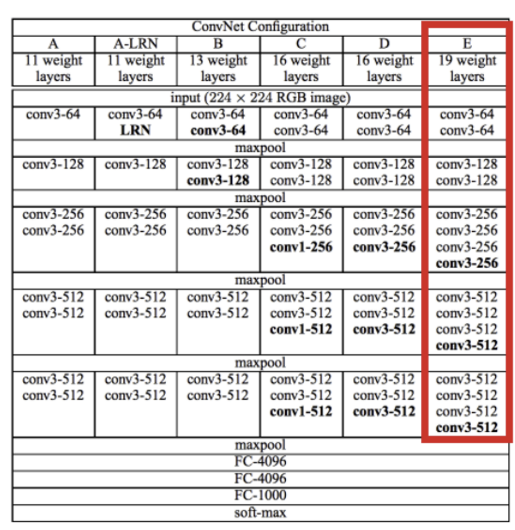

In [ ]:
# Encoder: encode the content and style images
vgg = nn.Sequential(
    nn.Conv2d(3, 3, (1, 1)), # 3 input channels, 3 output channels, 1x1 kernel
    nn.ReflectionPad2d((1, 1, 1, 1)),  # preserve the information at the borders
    nn.Conv2d(3, 64, (3, 3)),
    nn.ReLU(), # relu1-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 64, (3, 3)),
    nn.ReLU(), # relu1-2
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),  # 2x2 max pooling layer, 2x2 stride, zero padding
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 128, (3, 3)),
    nn.ReLU(), # relu2-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 128, (3, 3)),
    nn.ReLU(), # relu2-2
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 256, (3, 3)),
    nn.ReLU(), # relu3-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(), # relu3-2
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(), # relu3-3
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(), # relu3-4
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 512, (3, 3)),
    nn.ReLU(), # relu4-1, this is the last layer used
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(), # relu4-2
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(), # relu4-3
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(), # relu4-4
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(), # relu5-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(), # relu5-2
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(), # relu5-3
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU() # relu5-4
)

In [ ]:
# Decoder: invert the AdaIN output to the image spaces
decoder = nn.Sequential(
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 256, (3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 128, (3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 128, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 64, (3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 64, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 3, (3, 3)),
)

In [ ]:
# pre-trained weights
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/Ebs6XES37otLgWW5cavCY9YByGOnXJD5wC0WZgQPp8vAJg?download=1 -O decoder.pth
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EXzxBZI0seBFuxucQjlShBEBtM7X5-Lmj-ceqZ5Fu96alA?download=1 -O vgg_normalised.pth

--2024-07-23 09:16:07--  https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/Ebs6XES37otLgWW5cavCY9YByGOnXJD5wC0WZgQPp8vAJg?download=1
Resolving postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)... 13.107.136.10, 13.107.138.10, 2620:1ec:8f8::10, ...
Connecting to postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)|13.107.136.10|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/dongbinna_postech_ac_kr/Documents/Research/models/AdaIN%20Style%20Transfer/decoder.pth?ga=1 [following]
--2024-07-23 09:16:09--  https://postechackr-my.sharepoint.com/personal/dongbinna_postech_ac_kr/Documents/Research/models/AdaIN%20Style%20Transfer/decoder.pth?ga=1
Reusing existing connection to postechackr-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 14023458 (13M) [application/octet-stream]
Saving to: ‘decoder.pth’

decoder.pth         100%[===================>]  13.37M  3.77MB/s    in 3.5s  

# AdaIN Net

In [ ]:
class Net(nn.Module):
    def __init__(self, encoder, decoder):
        super(Net, self).__init__()
        enc_layers = list(encoder.children())
        self.enc_1 = nn.Sequential(*enc_layers[:4]) # input -> relu1_1
        self.enc_2 = nn.Sequential(*enc_layers[4:11]) # relu1_1 -> relu2_1
        self.enc_3 = nn.Sequential(*enc_layers[11:18]) # relu2_1 -> relu3_1
        self.enc_4 = nn.Sequential(*enc_layers[18:31]) # relu3_1 -> relu4_1
        self.decoder = decoder
        self.mse_loss = nn.MSELoss()  # Mean Squared Error

        # fix the encoder
        for name in ['enc_1', 'enc_2', 'enc_3', 'enc_4']:
            for param in getattr(self, name).parameters():
                param.requires_grad = False

    # extract relu1_1, relu2_1, relu3_1, relu4_1 from input image
    def encode_with_intermediate(self, input):
        results = [input]
        for i in range(4):
            func = getattr(self, 'enc_{:d}'.format(i + 1))
            results.append(func(results[-1]))
        return results[1:]

    # extract relu4_1 from input image
    def encode(self, input):
        for i in range(4):
            input = getattr(self, 'enc_{:d}'.format(i + 1))(input)
        return input

    # content loss
    def calc_content_loss(self, input, target):
        assert (input.size() == target.size())
        assert (target.requires_grad is False)
        # the Eucllidean distance between the target features and the features of the output image
        return self.mse_loss(input, target)

    # style loss
    def calc_style_loss(self, input, target):
        assert (input.size() == target.size())
        assert (target.requires_grad is False)
        input_mean, input_std = calc_mean_std(input)
        target_mean, target_std = calc_mean_std(target)
        return self.mse_loss(input_mean, target_mean) + self.mse_loss(input_std, target_std)

   # content-style trade-off
    def forward(self, content, style, alpha=1.0):
        assert 0 <= alpha <= 1
        # output image gets similar to content image when alpha approaches 0
        # synthesize the most stylized image when alpha = 1.0
        style_feats = self.encode_with_intermediate(style)  # f(s)
        content_feat = self.encode(content)  # f(c)
        t = adain(content_feat, style_feats[-1])
        t = alpha * t + (1 - alpha) * content_feat
        g_t = self.decoder(t) # output image
        # T(c, s, alpha) = g((1 - alpha) * f(c) + alpha * AdaIN(f(c), f(s)))
        g_t_feats = self.encode_with_intermediate(g_t)

        # return content loss and style loss
        loss_c = self.calc_content_loss(g_t_feats[-1], t)
        loss_s = self.calc_style_loss(g_t_feats[0], style_feats[0])
        for i in range(1, 4):
            loss_s += self.calc_style_loss(g_t_feats[i], style_feats[i])
        return loss_c, loss_s

In [ ]:
# model.eval(): deactivate dropout and batch normalization
decoder.eval()
vgg.eval()

# load pre-trained weights
vgg_path = '/content/vgg_normalised.pth'
decoder_path = '/content/decoder.pth'

decoder.load_state_dict(torch.load(decoder_path))
vgg.load_state_dict(torch.load(vgg_path))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vgg.to(device)
decoder.to(device)

vgg = nn.Sequential(*list(vgg.children())[:31])   # ReLU4_1까지만 사용

# Style Transfer

In [ ]:
def style_transfer(vgg, decoder, content, style, alpha = 1.0):
  assert (0.0 <= alpha <= 1.0)
  content_f = vgg(content)
  style_f = vgg(style)
  feat = adain(content_f, style_f)
  feat = feat * alpha + content_f * (1 - alpha)
  return decoder(feat)

In [ ]:
def test_transform(size = (512, 512)):
  transform_list = []
  if size != 0:
    transform_list.append(transforms.Resize(size))
  transform_list.append(transforms.ToTensor())
  transform = transforms.Compose(transform_list)
  return transform

content_tf = test_transform()
style_tf = test_transform()

# Implementation

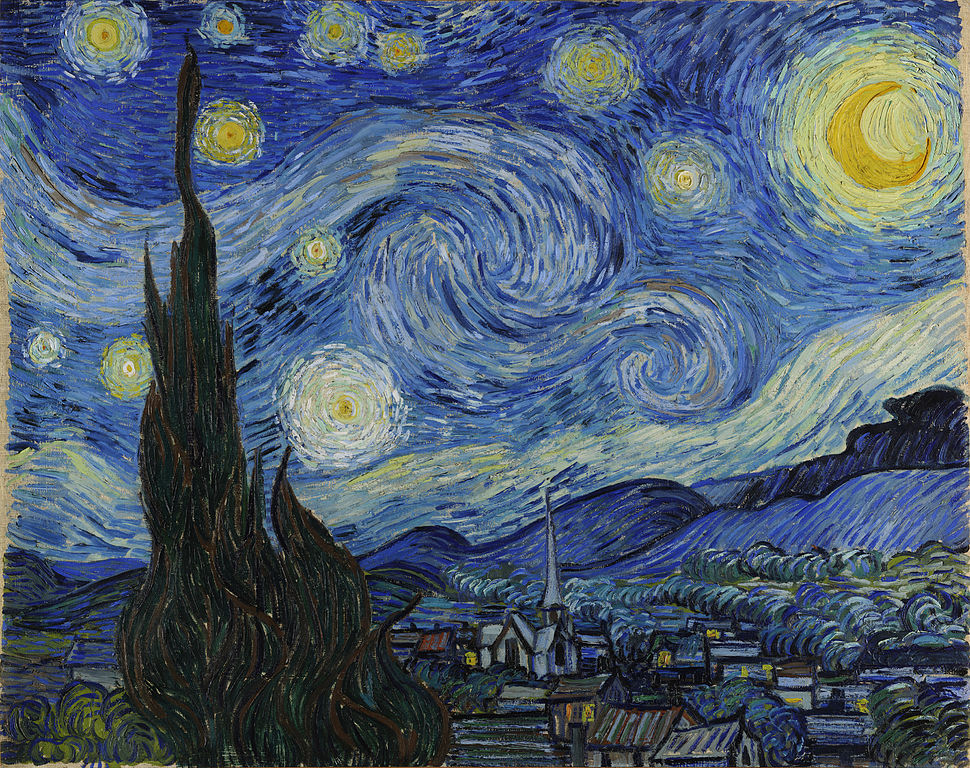

In [ ]:
style_path = '/content/style_1.jpg'
display_image(style_path)

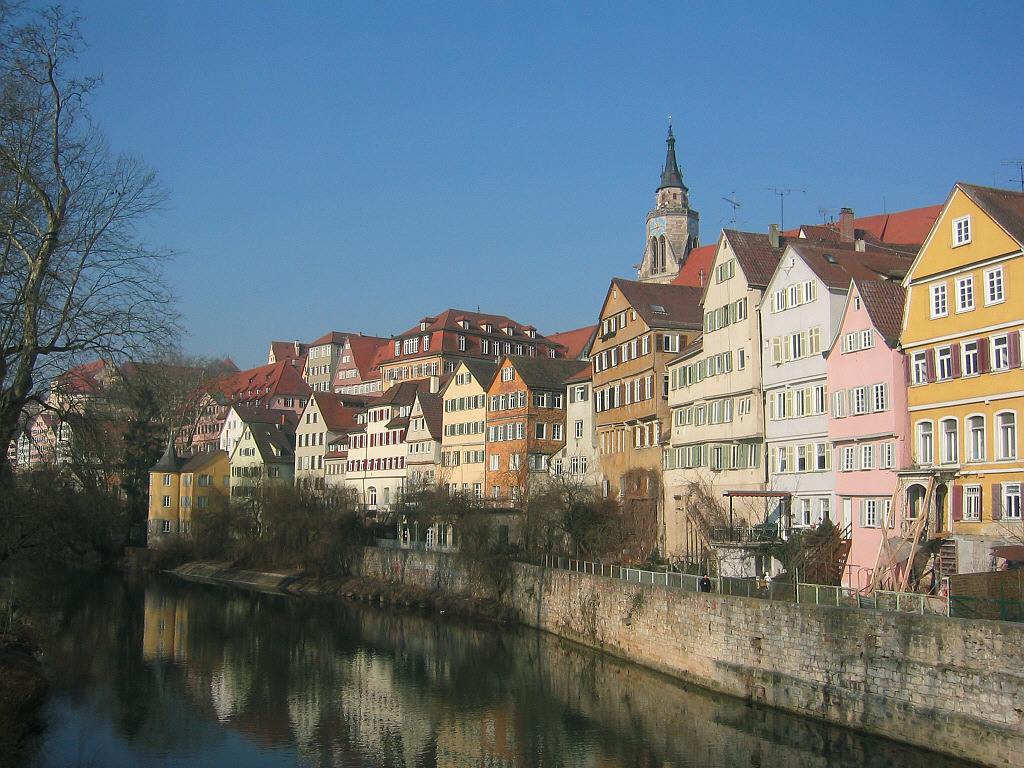

In [ ]:
content_path = '/content/content.jpg'
display_image(content_path)

In [ ]:
output_path = '/content/output.jpg'

content = content_tf(Image.open(str(content_path)))
style = style_tf(Image.open(str(style_path)))

style = style.to(device).unsqueeze(0)
content = content.to(device).unsqueeze(0)
with torch.no_grad():
    output = style_transfer(vgg, decoder, content, style, alpha=1.0)
output = output.cpu()

save_image(output, 'output.jpg')

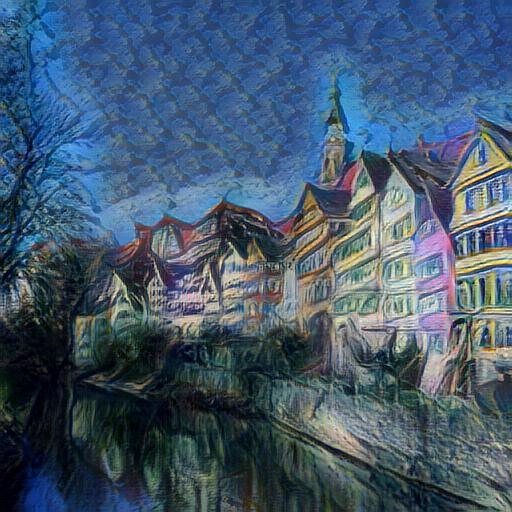

In [ ]:
display_image('/content/output.jpg')